In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
df = pd.read_csv('smoking.csv')
df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


In [2]:
pivot_df = df.pivot(index='state', columns='year', values='cigsale')
pivot_df.head()

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
state,,,,,,,,,,,,,,,,,,,,,
1,89.800003,95.400002,101.099998,102.900002,108.199997,111.699997,116.199997,117.099998,123.000000,121.400002,...,107.900002,109.099998,108.500000,107.099998,102.599998,101.400002,104.900002,106.199997,100.699997,96.199997
2,100.300003,104.099998,103.900002,108.000000,109.699997,114.800003,119.099998,122.599998,127.300003,126.500000,...,116.800003,126.000000,113.800003,108.800003,113.000000,110.699997,108.699997,109.500000,104.800003,99.400002
3,123.000000,121.000000,123.500000,124.400002,126.699997,127.099998,128.000000,126.400002,126.099998,121.900002,...,68.699997,67.500000,63.400002,58.599998,56.400002,54.500000,53.799999,52.299999,47.200001,41.599998
4,124.800003,125.500000,134.300003,137.899994,132.800003,131.000000,134.199997,132.000000,129.199997,131.500000,...,90.199997,88.300003,88.599998,89.099998,85.400002,83.099998,81.300003,81.199997,79.599998,73.000000
5,120.000000,117.599998,110.800003,109.300003,112.400002,110.199997,113.400002,117.300003,117.500000,117.400002,...,86.699997,83.500000,79.099998,76.599998,79.300003,76.000000,75.900002,75.500000,73.400002,71.400002


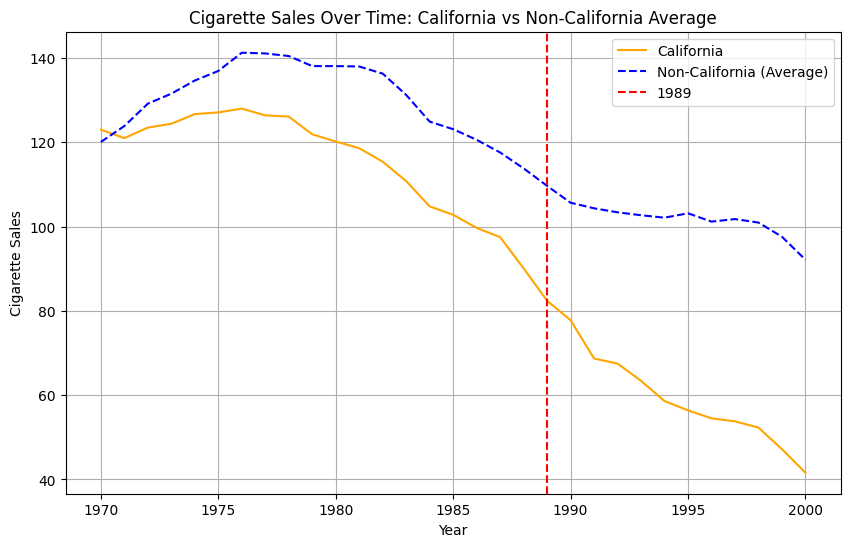

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('smoking.csv')
pivot_df = df.pivot(index='state', columns='year', values='cigsale')
non_california_avg = pivot_df.drop(index=3).mean()
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.columns, pivot_df.loc[3], label='California', color='orange')
plt.plot(pivot_df.columns, non_california_avg, label='Non-California (Average)', color='blue', linestyle='--')
plt.axvline(x=1989, color='red', linestyle='--', label='1989')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Cigarette Sales Over Time: California vs Non-California Average')
plt.grid(True)
plt.legend()
plt.show()

Validation RMSE (Pre-period 90:10 split): 3.7178861928815827
States with Largest Coefficients (absolute):
State: 17, Coefficient: -0.2434640485439711
State: 19, Coefficient: 0.22401331765305083
State: 34, Coefficient: 0.21341658390393647
State: 5, Coefficient: 0.2100523055813669
State: 21, Coefficient: 0.1515087681488955


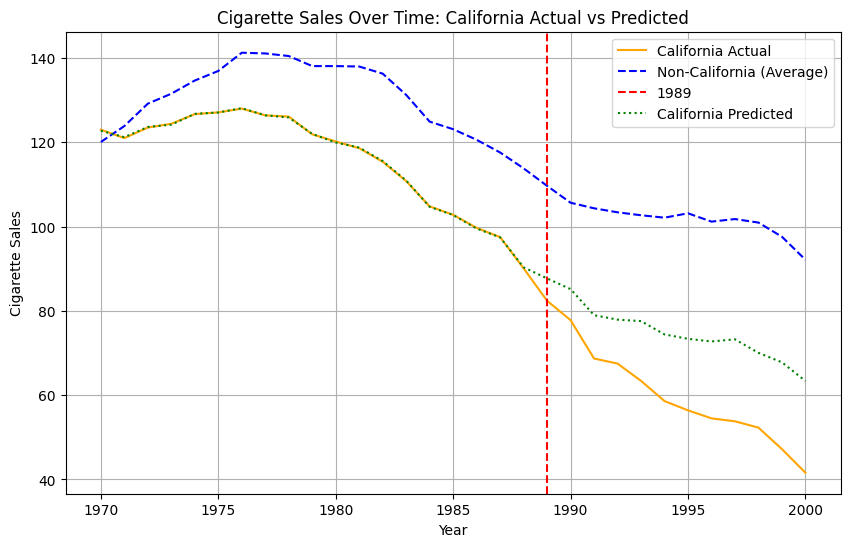

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
pre_period_years = pivot_df.columns[pivot_df.columns < 1989]
X_pre = pivot_df.drop(index=3)[pre_period_years].T
y_pre = pivot_df.loc[3, pre_period_years].T
lambda_= 0.1
lasso_model = Lasso(alpha=lambda_).fit(X_pre, y_pre)
split_index = int(len(pre_period_years) * 0.9)
X_train, X_val = X_pre.iloc[:split_index], X_pre.iloc[split_index:]
y_train, y_val = y_pre.iloc[:split_index], y_pre.iloc[split_index:]
lasso_model_val = Lasso(alpha=lambda_).fit(X_train, y_train)
val_predictions = lasso_model_val.predict(X_val)
rmse_val = mean_squared_error(y_val, val_predictions, squared=False)
print(f"Validation RMSE (Pre-period 90:10 split): {rmse_val}")
lasso_model_final = Lasso(alpha=lambda_).fit(X_pre, y_pre)
california_predictions = lasso_model_final.predict(pivot_df.drop(index=3).T)
lasso_coeffs = lasso_model_final.coef_
state_indices = np.argsort(np.abs(lasso_coeffs))[::-1]
largest_coeff_states = pivot_df.drop(index=3).index[state_indices[:5]]
largest_coeff_values = lasso_coeffs[state_indices[:5]]
print("States with Largest Coefficients (absolute):")
for state, coeff in zip(largest_coeff_states, largest_coeff_values):
    state_name = df[df['state'] == state]['state'].iloc[0]  # Get the name or ID of the state
    print(f"State: {state_name}, Coefficient: {coeff}")
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.columns, pivot_df.loc[3], label='California Actual', color='orange')
plt.plot(pivot_df.columns, pivot_df.drop(index=3).mean(), label='Non-California (Average)', color='blue', linestyle='--')
plt.axvline(x=1989, color='red', linestyle='--', label='1989')
plt.plot(pivot_df.columns, california_predictions, label='California Predicted', color='green', linestyle=':')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Cigarette Sales Over Time: California Actual vs Predicted')
plt.grid(True)
plt.legend()
plt.show()

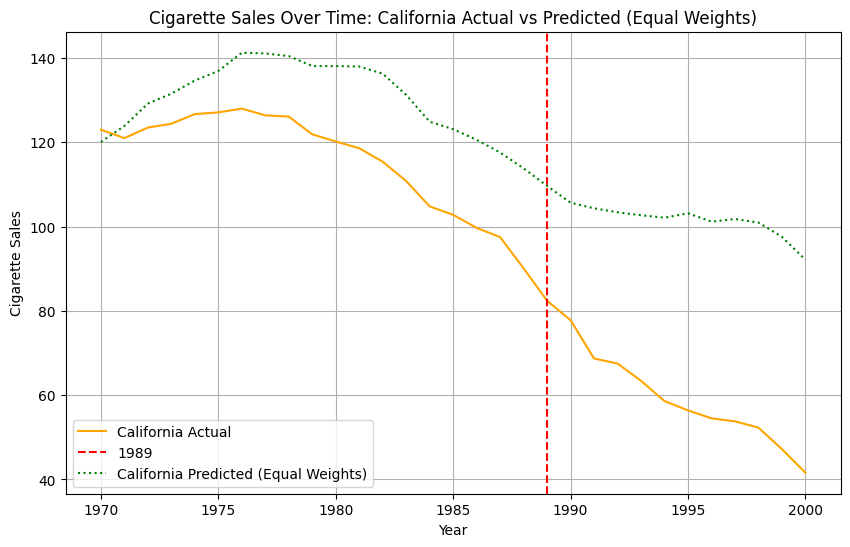

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
df = pd.read_csv('smoking.csv')
pivot_df = df.pivot(index='state', columns='year', values='cigsale')
pre_period_years = pivot_df.columns[pivot_df.columns < 1989]
X_pre = pivot_df.drop(index=3)[pre_period_years].T
y_pre = pivot_df.loc[3, pre_period_years].T
california_predictions_equal_weights = X_pre.mean(axis=1)
all_years = pivot_df.columns
full_predictions_equal_weights = pivot_df.drop(index=3).mean(axis=0)
plt.figure(figsize=(10, 6))
plt.plot(all_years, pivot_df.loc[3], label='California Actual', color='orange')
#plt.plot(all_years, pivot_df.drop(index=3).mean(), label='Non-California (Average)', color='blue', linestyle='--')
plt.axvline(x=1989, color='red', linestyle='--', label='1989')
plt.plot(all_years, full_predictions_equal_weights, label='California Predicted (Equal Weights)', color='green', linestyle=':')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Cigarette Sales Over Time: California Actual vs Predicted (Equal Weights)')
plt.grid(True)
plt.legend()
plt.show()

     pcost       dcost       gap    pres   dres
 0: -2.5905e+05 -2.5905e+05  5e+01  7e+00  2e-06
 1: -2.5905e+05 -2.5905e+05  5e+00  6e-01  2e-07
 2: -2.5905e+05 -2.5905e+05  3e+00  3e-01  9e-08
 3: -2.5905e+05 -2.5905e+05  2e+00  2e-01  6e-08
 4: -2.5905e+05 -2.5904e+05  3e+00  2e-01  5e-08
 5: -2.5905e+05 -2.5904e+05  5e+00  1e-01  4e-08
 6: -2.5904e+05 -2.5903e+05  6e+00  1e-01  3e-08
 7: -2.5903e+05 -2.5902e+05  8e+00  7e-02  2e-08
 8: -2.5903e+05 -2.5902e+05  9e+00  6e-02  2e-08
 9: -2.5903e+05 -2.5901e+05  9e+00  5e-02  1e-08
10: -2.5902e+05 -2.5900e+05  8e+00  3e-02  7e-09
11: -2.5900e+05 -2.5900e+05  2e+00  3e-03  9e-10
12: -2.5900e+05 -2.5900e+05  2e-02  3e-05  1e-11
13: -2.5900e+05 -2.5900e+05  2e-04  3e-07  1e-13
14: -2.5900e+05 -2.5900e+05  2e-06  3e-09  1e-15
Optimal solution found.
Optimal weights: [-4.36663091e-10 -3.41052796e-10  1.48107756e-02  1.09089628e-01
 -3.37944756e-10 -4.11777476e-10 -1.30061039e-10  5.43455921e-10
 -4.00304541e-10 -3.66132853e-10  1.21600305e-

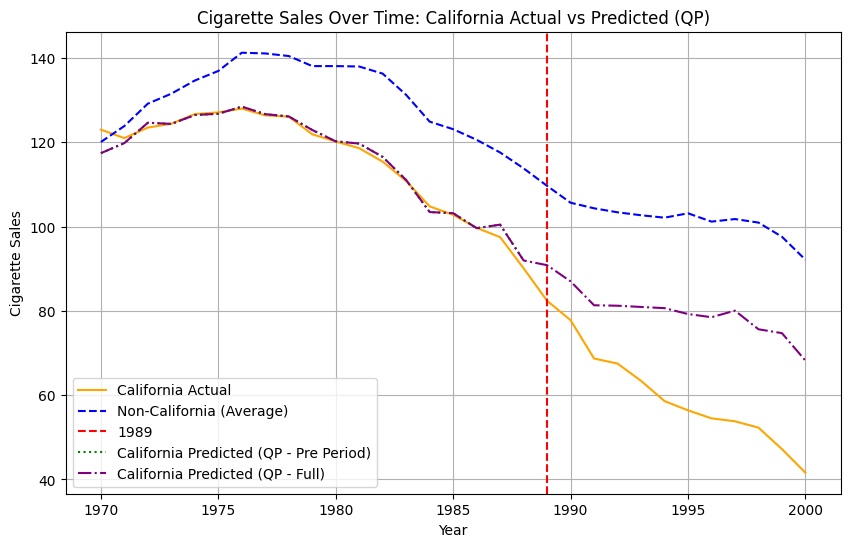

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
df = pd.read_csv('smoking.csv')
pivot_df = df.pivot(index='state', columns='year', values='cigsale')
pre_period_years = pivot_df.columns[pivot_df.columns < 1989]
X_pre = pivot_df.drop(index=3)[pre_period_years].T.values
y_pre = pivot_df.loc[3, pre_period_years].T.values
J = X_pre.shape[1]
Q = 2 * matrix(np.dot(X_pre.T, X_pre))
p = -2 * matrix(np.dot(X_pre.T, y_pre))
G = matrix(-np.eye(J))  # Enforcing w_k >= 0 for all k
h = matrix(np.zeros(J))
A = matrix(1.0, (1, J))  # Enforcing sum of weights equals 1
b = matrix(1.0)
sol = solvers.qp(Q, p, G, h, A, b)
w_optimal = np.array(sol['x']).flatten()
print("Optimal weights:", w_optimal)
print("Solver details:", sol)
california_predictions_qp = np.dot(X_pre, w_optimal)
full_predictions_qp = np.dot(pivot_df.drop(index=3).T.values, w_optimal)
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.columns, pivot_df.loc[3], label='California Actual', color='orange')
plt.plot(pivot_df.columns, pivot_df.drop(index=3).mean(), label='Non-California (Average)', color='blue', linestyle='--')
plt.axvline(x=1989, color='red', linestyle='--', label='1989')
plt.plot(pre_period_years, california_predictions_qp, label='California Predicted (QP - Pre Period)', color='green', linestyle=':')
plt.plot(pivot_df.columns, full_predictions_qp, label='California Predicted (QP - Full)', color='purple', linestyle='-.')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Cigarette Sales Over Time: California Actual vs Predicted (QP)')
plt.grid(True)
plt.legend()
plt.show()

     pcost       dcost       gap    pres   dres
 0: -1.3634e+04 -1.3635e+04  5e+01  7e+00  4e-05
 1: -1.3634e+04 -1.3635e+04  5e+00  6e-01  3e-06
 2: -1.3634e+04 -1.3634e+04  1e+00  2e-01  1e-06
 3: -1.3634e+04 -1.3633e+04  9e-01  9e-02  5e-07
 4: -1.3633e+04 -1.3632e+04  7e-01  6e-02  3e-07
 5: -1.3633e+04 -1.3632e+04  6e-01  4e-02  2e-07
 6: -1.3632e+04 -1.3631e+04  2e-01  5e-03  3e-08
 7: -1.3631e+04 -1.3631e+04  3e-03  7e-05  4e-10
 8: -1.3631e+04 -1.3631e+04  3e-05  7e-07  4e-12
 9: -1.3631e+04 -1.3631e+04  3e-07  7e-09  4e-14
Optimal solution found.


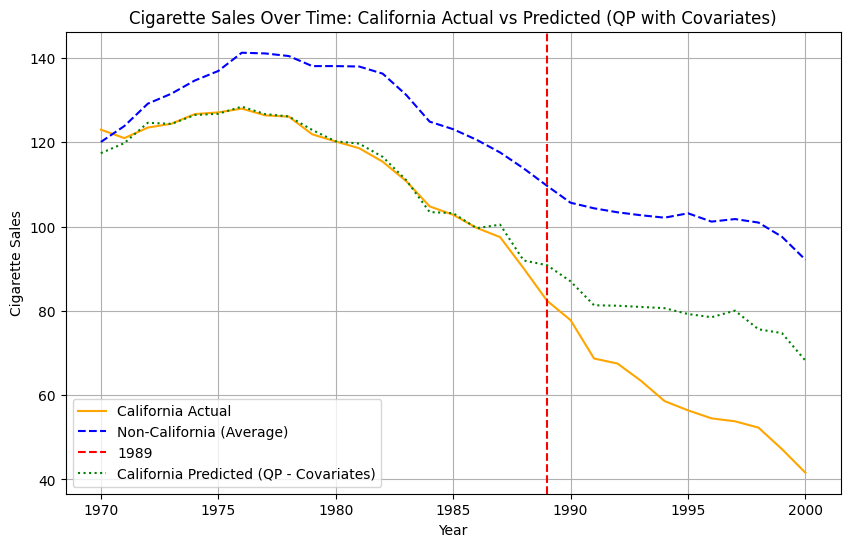

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers

# Load data
df = pd.read_csv('smoking.csv')
pivot_df = df.pivot(index='state', columns='year', values='cigsale')

# Separate pre-period data (before 1989) for California and other states
pre_period_years = pivot_df.columns[pivot_df.columns < 1989]
X_pre = pivot_df.drop(index=3)[pre_period_years].T.values
R_pre = pivot_df.drop(index=3)[pre_period_years].T.values  # Same as X_pre here (as we do not have extra covariates)
R_cali = pivot_df.loc[3, pre_period_years].T.values
P = R_pre.shape[0]

# Set up the new optimization problem with equal covariate weights (1/P)
J = R_pre.shape[1]
Q = 2 * matrix(np.dot(R_pre.T, R_pre) / P)
p = -2 * matrix(np.dot(R_pre.T, R_cali) / P)
G = matrix(-np.eye(J))
h = matrix(np.zeros(J))
A = matrix(1.0, (1, J))
b = matrix(1.0)

# Solve the QP problem
sol = solvers.qp(Q, p, G, h, A, b)
w_optimal = np.array(sol['x']).flatten()

# Calculate predictions using the new weights
california_predictions_qp = np.dot(X_pre, w_optimal)
full_predictions_qp = np.dot(pivot_df.drop(index=3).T.values, w_optimal)

# Calculate average non-California cigarette sales for plotting
avg_non_california = pivot_df.drop(index=3).mean(axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.columns, pivot_df.loc[3], label='California Actual', color='orange')
plt.plot(pivot_df.columns, avg_non_california, label='Non-California (Average)', color='blue', linestyle='--')
plt.axvline(x=1989, color='red', linestyle='--', label='1989')
plt.plot(pivot_df.columns, full_predictions_qp, label='California Predicted (QP - Covariates)', color='green', linestyle=':')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Cigarette Sales Over Time: California Actual vs Predicted (QP with Covariates)')
plt.grid(True)
plt.legend()
plt.show()


     pcost       dcost       gap    pres   dres
 0: -2.5905e+05 -2.5905e+05  5e+01  7e+00  2e-06
 1: -2.5905e+05 -2.5905e+05  5e+00  6e-01  2e-07
 2: -2.5905e+05 -2.5905e+05  3e+00  3e-01  9e-08
 3: -2.5905e+05 -2.5905e+05  2e+00  2e-01  6e-08
 4: -2.5905e+05 -2.5904e+05  3e+00  2e-01  5e-08
 5: -2.5905e+05 -2.5904e+05  5e+00  1e-01  4e-08
 6: -2.5904e+05 -2.5903e+05  6e+00  1e-01  3e-08
 7: -2.5903e+05 -2.5902e+05  8e+00  7e-02  2e-08
 8: -2.5903e+05 -2.5902e+05  9e+00  6e-02  2e-08
 9: -2.5903e+05 -2.5901e+05  9e+00  5e-02  1e-08
10: -2.5902e+05 -2.5900e+05  8e+00  3e-02  7e-09
11: -2.5900e+05 -2.5900e+05  2e+00  3e-03  9e-10
12: -2.5900e+05 -2.5900e+05  2e-02  3e-05  1e-11
13: -2.5900e+05 -2.5900e+05  2e-04  3e-07  1e-13
14: -2.5900e+05 -2.5900e+05  2e-06  3e-09  1e-15
Optimal solution found.


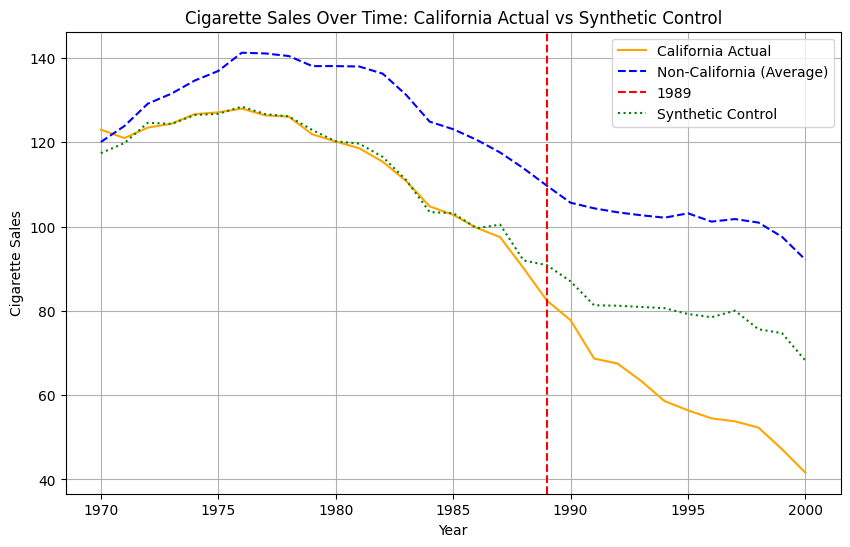

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers

# Load data
df = pd.read_csv('smoking.csv')
pivot_df = df.pivot(index='state', columns='year', values='cigsale')

# Separate pre-period data (before 1989) for California and other states
pre_period_years = pivot_df.columns[pivot_df.columns < 1989]
Y_cali = pivot_df.loc[3, pre_period_years].values  # California's pre-period cigsale data, shape (T,)

Y_donors = pivot_df.drop(index=3)[pre_period_years].values.T  # Other states' pre-period cigsale data, shape (T, J)

# Set up the QP problem for finding w_k
Q_w = 2 * matrix(np.dot(Y_donors.T, Y_donors))
p_w = -2 * matrix(np.dot(Y_donors.T, Y_cali))

J = Y_donors.shape[1]  # Number of donor states

G_w = matrix(-np.eye(J))  # Enforcing w_k >= 0 for all k
h_w = matrix(np.zeros(J))
A_w = matrix(1.0, (1, J))  # Enforcing sum of w_k equals 1
b_w = matrix(1.0)

# Solve the QP problem to find w_k
sol_w = solvers.qp(Q_w, p_w, G_w, h_w, A_w, b_w)
w_optimal = np.array(sol_w['x']).flatten()

# Use the weights to construct the synthetic control
Y_synth = np.dot(pivot_df.drop(index=3).values.T, w_optimal)

# Calculate average non-California cigarette sales for plotting
avg_non_california = pivot_df.drop(index=3).mean(axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.columns, pivot_df.loc[3], label='California Actual', color='orange')
plt.plot(pivot_df.columns, avg_non_california, label='Non-California (Average)', color='blue', linestyle='--')
plt.axvline(x=1989, color='red', linestyle='--', label='1989')
plt.plot(pivot_df.columns, Y_synth, label='Synthetic Control', color='green', linestyle=':')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Cigarette Sales Over Time: California Actual vs Synthetic Control')
plt.grid(True)
plt.legend()
plt.show()

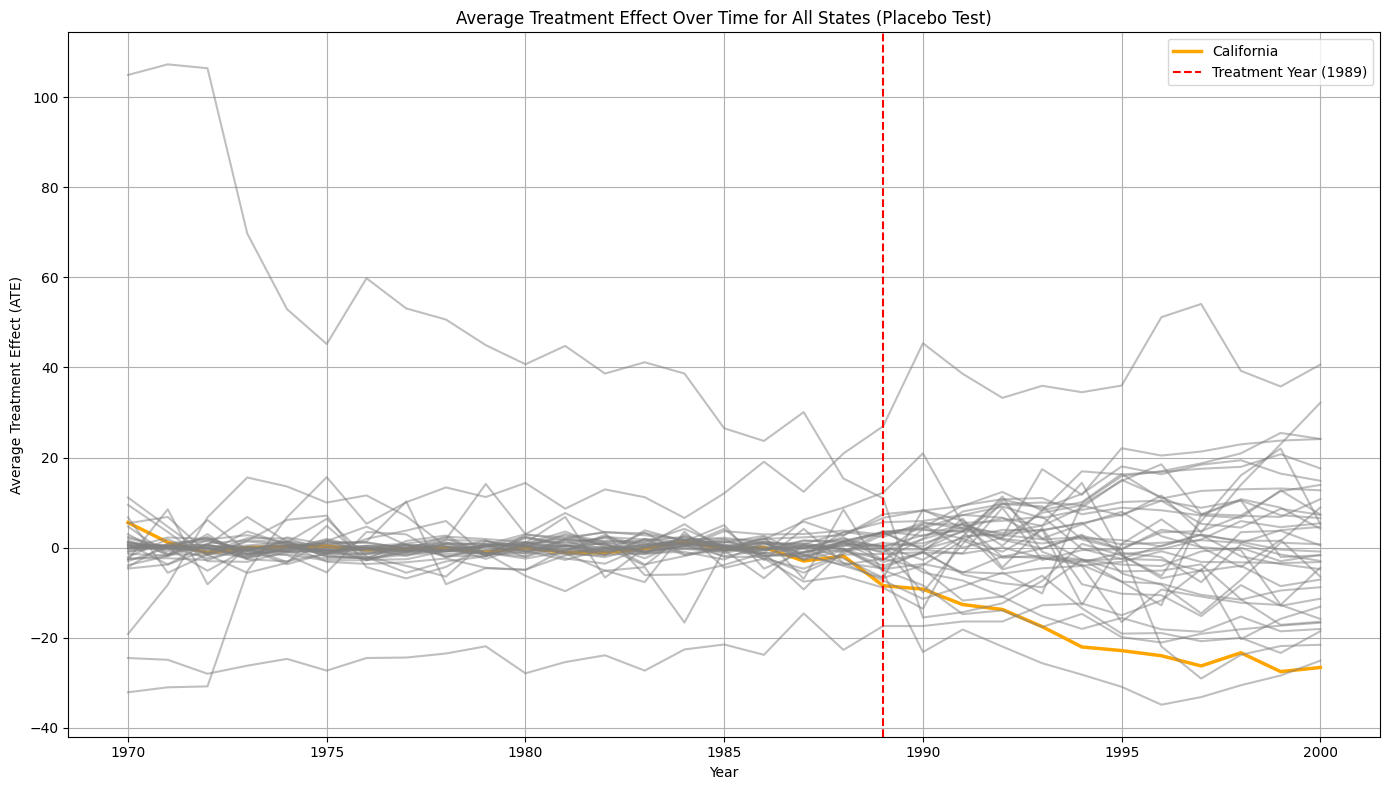

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers

# Suppress cvxopt solver output
solvers.options['show_progress'] = False

# Load data
df = pd.read_csv('smoking.csv')
pivot_df = df.pivot(index='state', columns='year', values='cigsale')

# Define the treatment year and pre-treatment years
treatment_year = 1989
pre_period_years = pivot_df.columns[pivot_df.columns < treatment_year]
post_period_years = pivot_df.columns[pivot_df.columns >= treatment_year]

# Function to compute synthetic control and ATE for a given state
def compute_synthetic_control(state_index):
    # Actual data for the state
    Y_actual = pivot_df.loc[state_index].values  # Shape (T_total,)
    
    # Pre-period data for the state
    Y_actual_pre = pivot_df.loc[state_index, pre_period_years].values  # Shape (T_pre,)
    
    # Donor pool excluding the state
    donor_states = pivot_df.drop(index=state_index)
    Y_donors_pre = donor_states[pre_period_years].values.T  # Shape (T_pre, J)
    Y_donors_full = donor_states.values.T  # Shape (T_total, J)
    
    # Set up the QP problem for finding weights
    Q = 2 * matrix(np.dot(Y_donors_pre.T, Y_donors_pre))
    p = -2 * matrix(np.dot(Y_donors_pre.T, Y_actual_pre))
    
    J = Y_donors_pre.shape[1]  # Number of donor states
    
    G = matrix(-np.eye(J))  # Enforcing weights >= 0
    h = matrix(np.zeros(J))
    A = matrix(1.0, (1, J))  # Sum of weights equals 1
    b = matrix(1.0)
    
    # Solve the QP problem to find weights
    sol = solvers.qp(Q, p, G, h, A, b)
    w_optimal = np.array(sol['x']).flatten()
    
    # Construct the synthetic control
    Y_synth = np.dot(Y_donors_full, w_optimal)  # Shape (T_total,)
    
    # Compute the ATE
    ATE = Y_actual - Y_synth  # Shape (T_total,)
    
    return ATE

# Compute the ATE for all states
ATEs = {}
for state in pivot_df.index:
    ATEs[state] = compute_synthetic_control(state)

# Identify California's index (assuming 'California' is the state name)
# If states are indexed by numbers, adjust accordingly
california_state = 'California'  # Replace with the actual identifier if different
if california_state not in pivot_df.index:
    # If 'state' is indexed by numbers and California is index 3 as in original code
    california_state = 3

ATE_california = ATEs[california_state]

# Plot all ATEs together, highlighting California
plt.figure(figsize=(14, 8))
for state, ATE in ATEs.items():
    if state == california_state:
        plt.plot(pivot_df.columns, ATE, label='California', color='orange', linewidth=2.5)
    else:
        plt.plot(pivot_df.columns, ATE, color='grey', alpha=0.5)

plt.axvline(x=treatment_year, color='red', linestyle='--', label='Treatment Year (1989)')
plt.xlabel('Year')
plt.ylabel('Average Treatment Effect (ATE)')
plt.title('Average Treatment Effect Over Time for All States (Placebo Test)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

{1: array([-4.64770847, -3.73181957, -0.51136428, -1.57427142,  0.62143709,
        0.77278955,  1.21007865, -0.19792838,  2.44274069,  1.91800355,
        1.22567307, -0.92258376, -0.4910209 , -1.49034236, -0.30702017,
       -0.79454982,  1.27124803, -0.12173626,  2.3240976 , -2.77788611,
        4.07055659,  1.97543436, -0.90169839,  3.87907208,  5.51164731,
       -1.55971119, -0.37612852,  1.81622872,  5.89468686,  4.54227097,
        5.41073341]), 2: array([ 2.06921284, -0.08978344, -5.11833134, -0.30329081, -3.6765504 ,
       -1.25633449, -1.39493126, -0.35751983,  0.98264983,  0.61288514,
        3.00428665,  1.64507517, -1.34601423,  1.94857288,  1.28117684,
        1.25773565,  1.05375256, -2.58355384,  1.53572635,  0.3222604 ,
       -2.72031293,  2.50762631, 11.36239679, -0.92605547, -4.01115759,
       -3.14418975, -0.80329058, -3.16990656, -3.25967212, -3.42904011,
       -3.19188367]), 3: array([  5.57595544,   1.1770114 ,  -1.14641241,   0.03277281,
         0.22630775

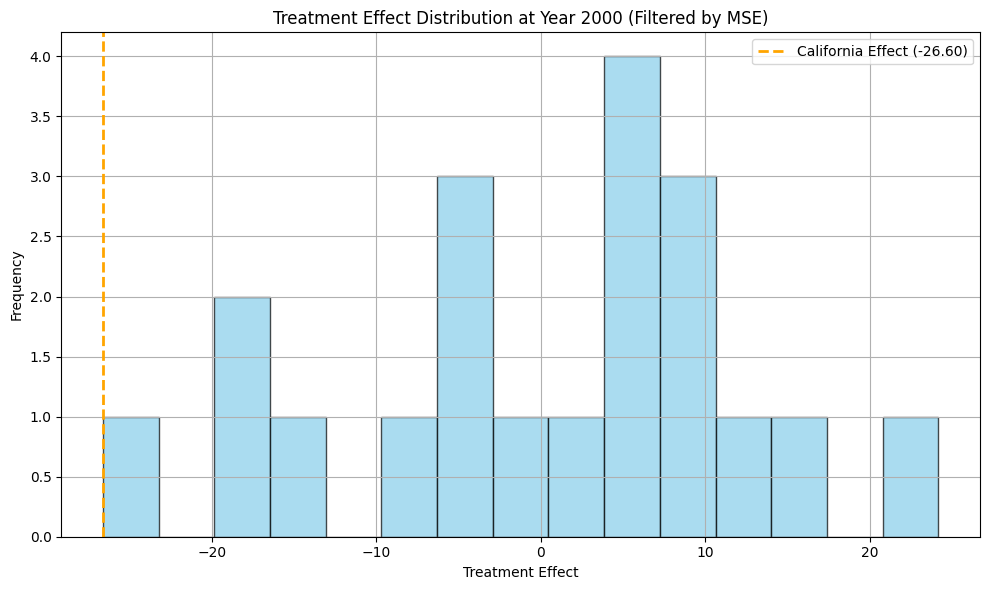

P-value for California's treatment effect being above zero at year 2000 (Filtered): 0.9500
Number of states dropped due to high pre-period MSE: 19


In [12]:
# Define MSE threshold for filtering states with poor pre-period fit
mse_threshold = 5  # Adjust this threshold based on your requirements

# Function to compute synthetic control, ATE, and pre-period MSE for a given state
def compute_synthetic_control_with_mse(state_index):
    Y_actual = pivot_df.loc[state_index].values
    Y_actual_pre = pivot_df.loc[state_index, pre_period_years].values
    
    donor_states = pivot_df.drop(index=state_index)
    Y_donors_pre = donor_states[pre_period_years].values.T
    Y_donors_full = donor_states.values.T
    
    Q = 2 * matrix(np.dot(Y_donors_pre.T, Y_donors_pre))
    p = -2 * matrix(np.dot(Y_donors_pre.T, Y_actual_pre))
    
    J = Y_donors_pre.shape[1]
    G = matrix(-np.eye(J))
    h = matrix(np.zeros(J))
    A = matrix(1.0, (1, J))
    b = matrix(1.0)
    
    sol = solvers.qp(Q, p, G, h, A, b)
    w_optimal = np.array(sol['x']).flatten()
    
    Y_synth = np.dot(Y_donors_full, w_optimal)
    
    # Calculate MSE in the pre-period
    Y_synth_pre = np.dot(Y_donors_pre, w_optimal)
    mse_pre = np.mean((Y_actual_pre - Y_synth_pre) ** 2)
    
    ATE = Y_actual - Y_synth
    
    return ATE, mse_pre

# Compute ATE and pre-period MSE for all states, filtering by MSE threshold
ATEs_filtered = {}
for state in pivot_df.index:
    ATE, mse_pre = compute_synthetic_control_with_mse(state)
    if mse_pre <= mse_threshold:
        ATEs_filtered[state] = ATE
print(ATEs_filtered)

# Check if California passed the MSE filter
if california_state in ATEs_filtered:
    ATE_california_filtered = ATEs_filtered[california_state]

    # Extract treatment effects at the test year for states passing the filter
    test_year = 2000
    test_year_index = list(pivot_df.columns).index(test_year)
    treatment_effects_at_test_year_filtered = np.array([ATE[test_year_index] for ATE in ATEs_filtered.values()])
    california_effect_at_test_year_filtered = ATE_california_filtered[test_year_index]

    # Plot distribution of treatment effects at the test year for filtered states
    plt.figure(figsize=(10, 6))
    plt.hist(treatment_effects_at_test_year_filtered, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(california_effect_at_test_year_filtered, color='orange', linestyle='--', linewidth=2, label=f'California Effect ({california_effect_at_test_year_filtered:.2f})')
    plt.title(f'Treatment Effect Distribution at Year {test_year} (Filtered by MSE)')
    plt.xlabel('Treatment Effect')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test the p-value for California's treatment effect being above zero (filtered)
    p_value_filtered = (treatment_effects_at_test_year_filtered > california_effect_at_test_year_filtered).mean()
    print(f'P-value for California\'s treatment effect being above zero at year {test_year} (Filtered): {p_value_filtered:.4f}')
else:
    print(f'California did not pass the MSE filter (Threshold: {mse_threshold})')

# Count the number of states dropped based on the MSE threshold
dropped_states_count = len(pivot_df) - len(ATEs_filtered)
print(f'Number of states dropped due to high pre-period MSE: {dropped_states_count}')

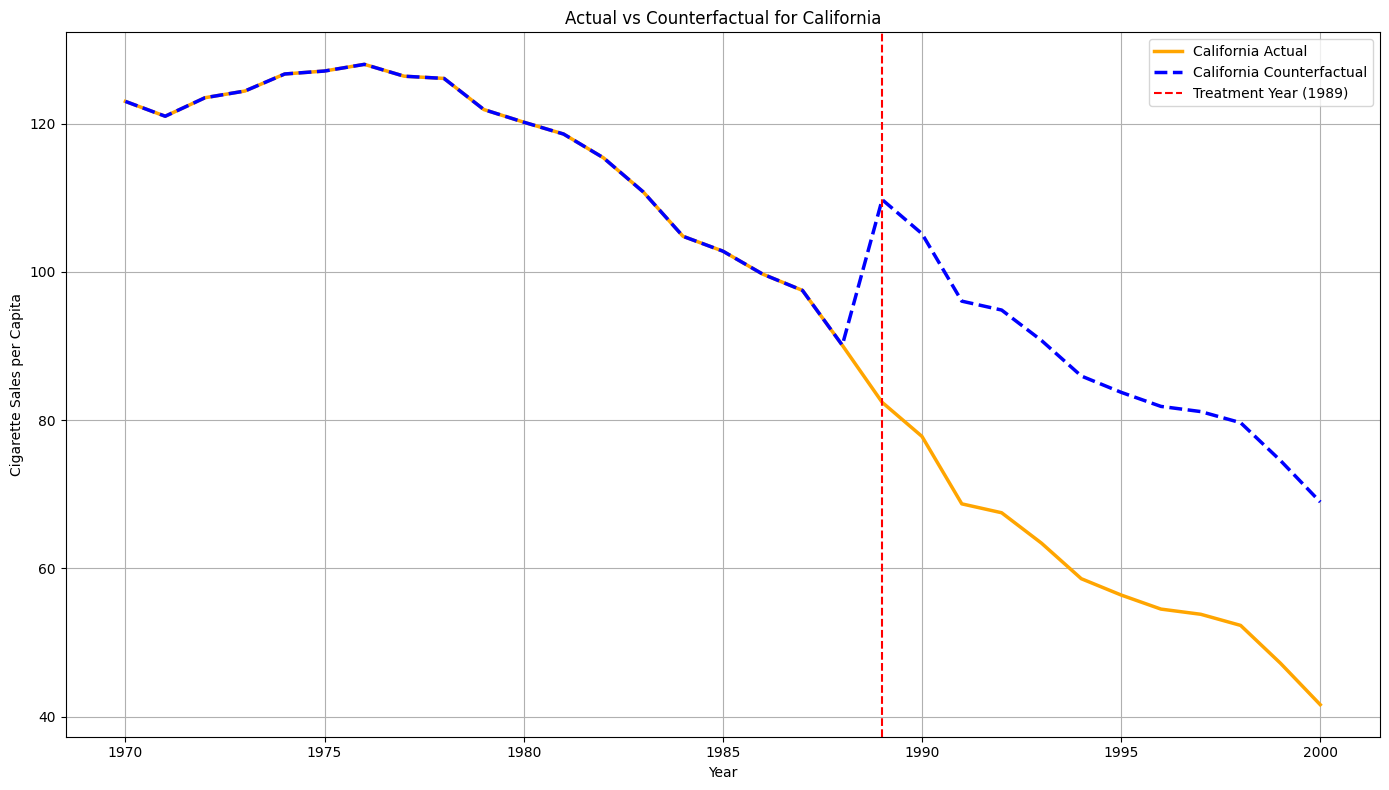

,state,year,Y_it,D_it,Y_demeaned,D_demeaned,Y_counterfactual
2,3,1970,123.000000,0,27.147145,-0.377171,123.000000
41,3,1971,121.000000,0,21.516377,-0.377171,121.000000
80,3,1972,123.500000,0,18.772787,-0.377171,123.500000
119,3,1973,124.400002,0,17.349712,-0.377171,124.400002
158,3,1974,126.699997,0,16.542016,-0.377171,126.699997


In [15]:
# Updating the code with the loaded dataset
# Pivot the dataframe to create the pivot_df similar to the original code

pivot_df = df.pivot(index='state', columns='year', values='cigsale')

# Step 1: Create dataset in long format
df_long = pivot_df.reset_index().melt(id_vars=['state'], var_name='year', value_name='Y_it')
df_long['D_it'] = ((df_long['state'] == 3) & (df_long['year'] >= 1989)).astype(int)  # California indexed by 3

# Step 2: Double demean the variables Y_it and D_it
mean_Y_over_states = df_long.groupby('year')['Y_it'].transform('mean')
mean_Y_over_years = df_long.groupby('state')['Y_it'].transform('mean')
df_long['Y_demeaned'] = df_long['Y_it'] - mean_Y_over_states - mean_Y_over_years + df_long['Y_it'].mean()

mean_D_over_states = df_long.groupby('year')['D_it'].transform('mean')
mean_D_over_years = df_long.groupby('state')['D_it'].transform('mean')
df_long['D_demeaned'] = df_long['D_it'] - mean_D_over_states - mean_D_over_years + df_long['D_it'].mean()

# Step 3: Simple regression of double demeaned Y_it on double demeaned D_it
from statsmodels.api import OLS, add_constant

X = add_constant(df_long['D_demeaned'])
model = OLS(df_long['Y_demeaned'], X).fit()
tau = model.params['D_demeaned']

# Step 4: Predict counterfactual for California using tau
# Extract the actual values for California
california_data = df_long[df_long['state'] == 3].copy()
california_data['Y_counterfactual'] = california_data['Y_it'] - california_data['D_it'] * tau

# Plot the actual and counterfactual for California
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(california_data['year'], california_data['Y_it'], label='California Actual', color='orange', linewidth=2.5)
plt.plot(california_data['year'], california_data['Y_counterfactual'], label='California Counterfactual', color='blue', linestyle='--', linewidth=2.5)
plt.axvline(x=1989, color='red', linestyle='--', label='Treatment Year (1989)')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales per Capita')
plt.title('Actual vs Counterfactual for California')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Displaying the dataframe to verify California data
california_data.head()


In [14]:
california_data

,state,year,Y_it,D_it,Y_demeaned,D_demeaned,Y_counterfactual
